# Quaternion Update

In [16]:
# load data
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *

# data loading
folder_path = '/Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/'
params = {'Ntrain': 80_000, 'Nval': 100, 'seq_len': 8, 
          'input': ['synced/acce', 'synced/magnet', 'synced/gyro'], 
          'output': ['pose/ekf_ori'], 
          'normalize': False}
X, y = load_split_data(folder_path, **params)

file_path = '../data/data_from_RoNIN/train_dataset_1/a002_1/data.hdf5'
data_dict = load_data(file_path, verbose=False)

# prepare data
## use only last ori as target
## and first ori as input as well as flatten the input
X = np.hstack( [ X.reshape(X.shape[0], -1), y[:,0,:] ] )
y = y[:,-1,:]

## train test split
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

## dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

## dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Loading file: /Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/a017_1/data.hdf5


(8009, 76) (8009, 4) (2003, 76) (2003, 4)


## NN

In [17]:
# Set no. of layers in model
Nlayers = 8
# Set neurons per layer in model
hidden_size = 256
# Set learning rate



# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)


class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        #x = self.fc_input(x)
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            #x = self.hidden_layers[i](x)
            
        x = self.fc_output(x)
        return x

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


model = Net(input_size=X_test.shape[1], output_size=4, hidden_size=hidden_size, num_layers=Nlayers)

# mount model to device
model = model.to(device)
# number of params
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Using device: cpu
Number of parameters: 547076


In [19]:
import time
learning_rate = 0.00001
# Set loss function
criterion = nn.L1Loss()
# set n_epochs
num_epochs = 2000

# try load model weights
try:
    model.load_state_dict(torch.load(f'checkpoint_{model.__class__.__name__}.pt'))
    print("Model weights loaded!")
except:
    print("No model weights found!")


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'checkpoint_{model.__class__.__name__}.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=50, verbose=True)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


t_start = time.time()
losses = {'train': [], 'test': []}
for epoch in range(num_epochs):
    try:
        running_loss = 0.0
        n_minibatches = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n_minibatches += 1
        print('Epoch %d, loss: %.5f' % (epoch+1, running_loss/n_minibatches))
        losses['train'].append(running_loss/n_minibatches)
        # test
        with torch.no_grad():
            running_loss = 0.0
            n_minibatches = 0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                n_minibatches += 1
            print('Test loss: %.5f' % (running_loss/n_minibatches))
            losses['test'].append(running_loss/n_minibatches)
        val_loss = running_loss/n_minibatches
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
                print("Early stopping")
                break
    except KeyboardInterrupt:
        print("Interrupted")
        break
t_end = time.time()
print("Training time: ", t_end - t_start)

No model weights found!
Epoch 1, loss: 0.36395
Test loss: 0.40390
Validation loss decreased (inf --> 0.403903).  Saving model ...
Epoch 2, loss: 0.33709
Test loss: 0.39735
Validation loss decreased (0.403903 --> 0.397352).  Saving model ...
Epoch 3, loss: 0.31964
Test loss: 0.39271
Validation loss decreased (0.397352 --> 0.392713).  Saving model ...
Epoch 4, loss: 0.30272
Test loss: 0.39100
Validation loss decreased (0.392713 --> 0.391000).  Saving model ...
Epoch 5, loss: 0.28637
Test loss: 0.38918
Validation loss decreased (0.391000 --> 0.389178).  Saving model ...
Epoch 6, loss: 0.26957
Test loss: 0.38947
EarlyStopping counter: 1 out of 50
Epoch 7, loss: 0.25381
Test loss: 0.38798
Validation loss decreased (0.389178 --> 0.387982).  Saving model ...
Epoch 8, loss: 0.24270
Test loss: 0.38783
Validation loss decreased (0.387982 --> 0.387828).  Saving model ...
Epoch 9, loss: 0.23464
Test loss: 0.38703
Validation loss decreased (0.387828 --> 0.387035).  Saving model ...
Epoch 10, loss: 

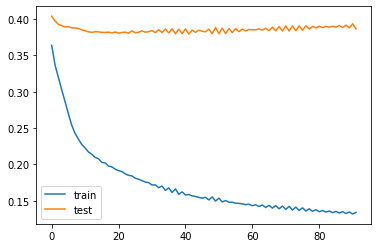

In [20]:

plt.figure()
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()

## Testing

In [21]:
# try load model weights
try:
    model.load_state_dict(torch.load(f'checkpoint_{model.__class__.__name__}.pt'))
    print("Model weights loaded!")
except:
    print("No model weights found!")

Model weights loaded!


q_pred (1000, 4) q_gt (1000, 4) x (1000,)
q_pred (50, 4) q_gt torch.Size([50, 4]) x (50,)


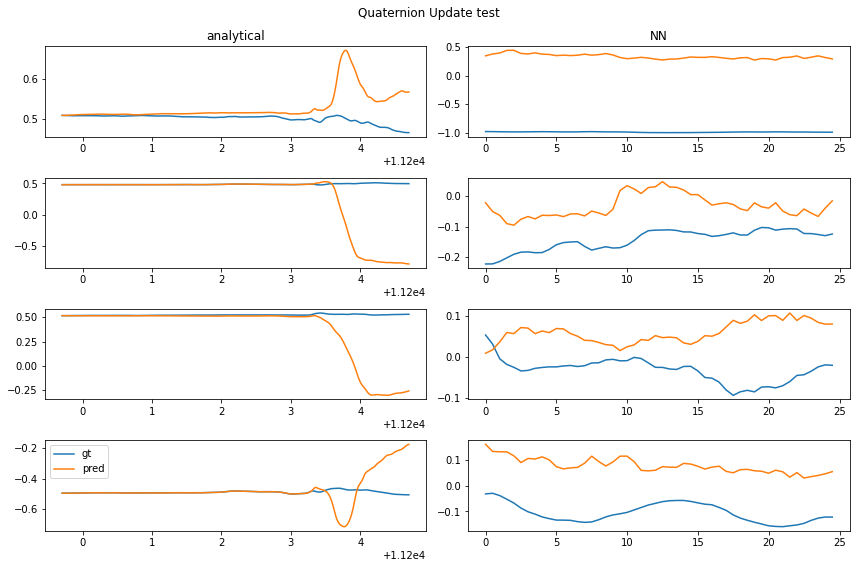

In [22]:
# Predict angles analytically
N = 1000
q_gt = data_dict['pose/tango_ori'][:N]
a = data_dict['synced/acce'][:N]
m = data_dict['synced/magnet'][:N]
w = data_dict['synced/gyro'][:N]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]

q_pred_ana = np.zeros((N,4))
q_pred_ana[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,N):
    q_pred_ana[i] = Theta(w[i]*factor, dt=dt)@q_pred_ana[i-1]


# plot
def plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN']):
    if type(q_preds) is not list:
        q_preds = [q_preds]
    if type(q_gts) is not list:
        q_gts = [q_gts]
    if type(xs) is not list:
        xs = [xs]
    
    fig, ax = plt.subplots(4,len(q_preds), figsize=(12, 4*len(q_preds)))
    ax = ax.reshape(4, -1).T
    idx = 0
    for q_pred, q_gt,x, name in zip(q_preds, q_gts,xs, names):
        print('q_pred', q_pred.shape, 'q_gt', q_gt.shape, 'x', x.shape)
        ax[idx, 0].plot(x, q_gt[:,0],)
        ax[idx, 0].plot(x, q_pred[:,0],)
        ax[idx, 1].plot(x, q_gt[:,1],)
        ax[idx, 1].plot(x, q_pred[:,1],)
        ax[idx, 2].plot(x, q_gt[:,2],)
        ax[idx, 2].plot(x, q_pred[:,2],)
        ax[idx, 3].plot(x, q_gt[:,3],label='gt')
        ax[idx, 3].plot(x, q_pred[:,3],label=f'pred')
        
        ax[idx, 0].set_title(name)
        idx += 1
    ax[0, 3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()


# testing NN

y_pred = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        if i > 0:
            X_test[i, -4:] = torch.tensor(y_pred[i-1])
        y_pred.append(model(X_test[i].to(device)).cpu().numpy())
y_pred = np.array(y_pred).squeeze()


up_to = 50
plot_quat([q_gt, y_test[:up_to]], 
          [q_pred_ana, y_pred[:up_to]], 
          [data_dict['synced/time'][:N], 
           np.linspace(0, N, len(y_test))[:up_to]], 
          names=['analytical', 'NN'])

q_pred (5000, 4) q_gt (5000, 4) x (5000,)
q_pred (5000, 4) q_gt (5000, 4) x (5000,)


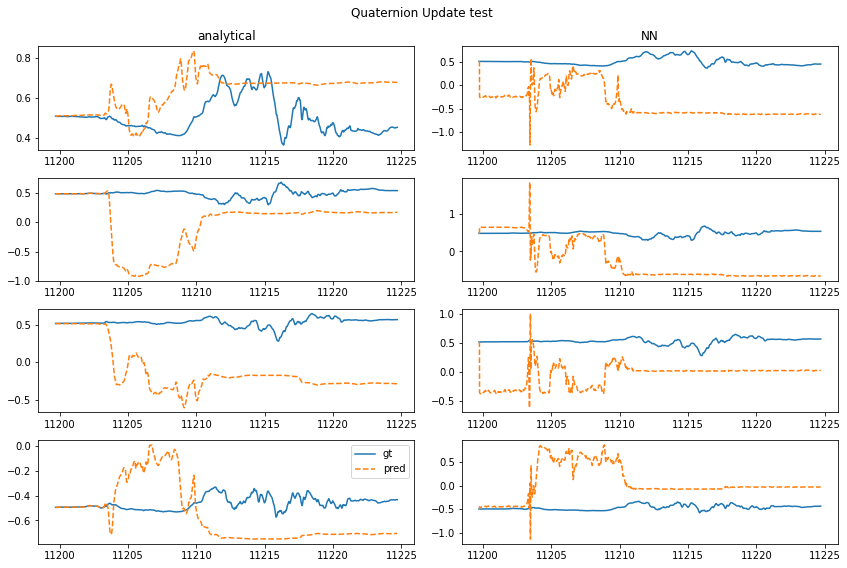

In [23]:
# plot
def plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN']):
    if type(q_preds) is not list:
        q_preds = [q_preds]
    if type(q_gts) is not list:
        q_gts = [q_gts]
    if type(xs) is not list:
        xs = [xs]
    
    fig, ax = plt.subplots(4,len(q_preds), figsize=(12, 4*len(q_preds)))
    ax = ax.reshape(4, -1).T
    idx = 0
    for q_pred, q_gt,x, name in zip(q_preds, q_gts,xs, names):
        print('q_pred', q_pred.shape, 'q_gt', q_gt.shape, 'x', x.shape)
        ax[idx, 0].plot(x, q_gt[:,0],)
        ax[idx, 0].plot(x, q_pred[:,0], ls='--')
        ax[idx, 1].plot(x, q_gt[:,1],)
        ax[idx, 1].plot(x, q_pred[:,1], ls='--')
        ax[idx, 2].plot(x, q_gt[:,2],)
        ax[idx, 2].plot(x, q_pred[:,2], ls='--')
        ax[idx, 3].plot(x, q_gt[:,3],label='gt')
        ax[idx, 3].plot(x, q_pred[:,3],label=f'pred', ls='--')
        
        ax[idx, 0].set_title(name)
        idx += 1
    ax[0, 3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()



N = 5000
q_gt = data_dict['pose/tango_ori'][:N]
a = data_dict['synced/acce'][:N]
m = data_dict['synced/magnet'][:N]
w = data_dict['synced/gyro'][:N]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]

# Predict angles analytically
q_pred_ana = np.zeros((N,4))
q_pred_ana[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,N):
    q_pred_ana[i] = Theta(w[i]*factor, dt=dt)@q_pred_ana[i-1]

# testing NN

y_pred_NN = np.zeros((N,4))

y_pred_NN[:params['seq_len']+1] = q_gt[:params['seq_len']+1]

with torch.no_grad():
    for i in range(N-params['seq_len']):

        X_line_np = np.hstack([a[i:i+params['seq_len']], 
                                 m[i:i+params['seq_len']],
                                    w[i:i+params['seq_len']], 
                                    ]).reshape(1, -1)
        X_line_np = np.hstack([X_line_np, np.zeros((1,4), dtype=np.float32)]) # add zeros for previous prediction
                      
        X_line_np[0,-4:] = torch.tensor(y_pred_NN[i+params['seq_len']-1])
        #print(i, X_line_np[0,-4:])  
        X_line_np = torch.tensor(X_line_np, dtype=torch.float32).to(device)
        y_pred_NN[i+params['seq_len']] = model(X_line_np).cpu().numpy()
        #y_pred_NN[i+params['seq_len']] /= np.linalg.norm(y_pred_NN[i+params['seq_len']])
    
y_pred_NN = np.array(y_pred_NN).squeeze()


plot_quat([q_gt, q_gt], 
          [q_pred_ana, y_pred_NN], 
          [data_dict['synced/time'][:N], 
           data_dict['synced/time'][:N]], 
          names=['analytical', 'NN'])